In [1]:
%load_ext watermark
%watermark

Last updated: 2022-09-12T15:35:52.770720+03:00

Python implementation: CPython
Python version       : 3.10.4
IPython version      : 8.4.0

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.15.0-47-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit



In [2]:
import time
notebookstart = time.time()

In [3]:
import os
from typing import List, Tuple, Optional

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostRegressor
from catboost import Pool, cv

/home/v010ch/anaconda3/envs/cardist22/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [4]:
%watermark --iversions

pandas    : 1.4.3
matplotlib: 3.5.3
numpy     : 1.23.2
seaborn   : 0.11.2



In [5]:
from catboost import __version__ as cb_version
print(f'cb_version: {cb_version}')

cb_version: 1.0.6


# Блок для воспроизводимости результатов

In [6]:
# seed the RNG for all devices (both CPU and CUDA)
#torch.manual_seed(1984)

#Disabling the benchmarking feature causes cuDNN to deterministically select an algorithm, 
#possibly at the cost of reduced performance.
#torch.backends.cudnn.benchmark = False

# for custom operators,
import random
random.seed(5986721)

# 
np.random.seed(62185)

#sklearn take seed from a line abowe

CB_RANDOMSEED  = 309487
XGB_RANDOMSEED = 56
LGB_RANDOMSEED = 874256

# Выставление констант

In [7]:
DIR_DATA = os.path.join(os.getcwd(), 'data')
DIR_SUBM = os.path.join(os.getcwd(), 'subm')
DIR_SUBM_TRAIN = os.path.join(os.getcwd(), 'subm', 'train')
DIR_DATA_TRAIN = os.path.join(DIR_DATA, 'train')
DIR_DATA_TEST  = os.path.join(DIR_DATA, 'test')

In [8]:
def plot_feature_importance(importance: np.ndarray, names: List[str], model_type: str, imp_number: Optional[int] = 30) -> None:
    """Графическое отображение важности признаков (по убыванияю) модели на основе величины влияния на предсказанные значения
    
    args:
        importance: массив важности признаков (получаемый из модели CatBoostRegressor)
        names:      список имен признаков
        model_type: имя модели
        imp_number: (опционально, 30) количество признаков для отображения
        
    return:
        None
    """
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data = {'feature_names': feature_names,'feature_importance': feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by = ['feature_importance'], ascending = False, inplace = True)
    
    #Define size of bar plot
    plt.figure(figsize = (10,8))
    #Plot Searborn bar chart
    sns.barplot(x = fi_df['feature_importance'][:imp_number], y = fi_df['feature_names'][:imp_number])
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

# Загрузка данных

In [9]:
train_df = pd.read_csv(os.path.join(DIR_DATA, 'train_upd.csv'))
test_df  = pd.read_csv(os.path.join(DIR_DATA, 'test_upd.csv'))
train_df.shape, test_df.shape

((530, 25), (517, 24))

In [10]:
train_df.head()

,image_name,distance,car_x_min,car_y_min,car_x_max,car_y_max,car_conf,car_class,car_h,car_w,...,log_car_w,tmp,plate_x_min,plate_y_min,plate_x_max,plate_y_max,plate_w,plate_h,log_plate_w,log_plate_h
0,img_1596.jpg,4.88,1661.429565,1172.557251,2280.754883,1717.927490,0.860230,2.0,545.370239,619.325317,...,6.428631,"(399, 214, 449, 419)",399.0,214.0,449.0,419.0,50.0,205.0,3.912023,5.323010
1,img_1600.jpg,1.54,1125.149536,1184.862671,3012.469971,2716.756592,0.852567,2.0,1531.893921,1887.320435,...,7.542913,"(1307, 608, 1504, 1324)",1307.0,608.0,1504.0,1324.0,197.0,716.0,5.283204,6.573680
2,img_1601.jpg,3.68,1573.088257,1192.642944,2434.746826,2020.067017,0.645506,2.0,827.424072,861.658569,...,6.758859,"(461, 292, 522, 578)",461.0,292.0,522.0,578.0,61.0,286.0,4.110874,5.655992
3,img_1603.jpg,2.22,2603.172363,1277.686401,3310.659912,1849.837769,0.782663,2.0,572.151367,707.487549,...,6.561720,"(258, 160, 507, 415)",258.0,160.0,507.0,415.0,249.0,255.0,5.517453,5.541264
4,img_1605.jpg,3.73,1612.237183,1101.504517,2481.318848,1924.509155,0.764224,2.0,823.004639,869.081665,...,6.767437,"(459, 289, 523, 575)",459.0,289.0,523.0,575.0,64.0,286.0,4.158883,5.655992


В данных присутствуют сильно размытые изображения. Ни рамка автомобиля, ни рамка автомобильного номера   
ни нах не могут быть определены с удовлетворяющей точностью. Так что обучение на них скорее вего ухудшит результат.   
Исключаем их из тренировочного датасета.

In [11]:
motion_blur_train = set(['img_2709.heic', 'img_2733.heic', 'img_2734.heic'])    # 'img_2734.heic' возможно рабочий 
print(train_df.shape)

for el in train_df.index:
    if train_df.loc[el, 'image_name'] in motion_blur_train:
        train_df.drop(el, inplace = True)

print(train_df.shape)

(530, 25)
(527, 25)


# Обучаем модель

По кросс валидации (3 фолда) определим оптимальное количество итераций (по лучшей средней RMSE на валидационных фолдах)     
Затем на этом количестве итераций обучим модель на всех данных.

In [12]:
%%time
params = {"iterations": 3500,
          "loss_function": 'RMSE',
          #'eval_metric': 'R2',
         }

features = ['log_plate_h', 'log_plate_w']

train = Pool(data = train_df[features],
             label = train_df[['distance']],
            )

scores = cv(train, params,
            fold_count = 3,
            verbose = False,
            plot = True,
           )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 0.6054798525
bestIteration = 243

Training on fold [1/3]

bestTest = 0.4264131689
bestIteration = 498

Training on fold [2/3]

bestTest = 0.7134457025
bestIteration = 139

CPU times: user 36.1 s, sys: 2.41 s, total: 38.5 s
Wall time: 7.33 s


выбираем оптимальное количество итераций

In [13]:
niter = scores['test-RMSE-mean'].argmin() + 13
scores['test-RMSE-mean'].min(), scores['test-RMSE-mean'].argmin(), niter

(0.5944935070222855, 262, 275)

Обучем на этом количестве итераций модель на всей обучающей выборке

In [14]:
%%time

model_cb = CatBoostRegressor(iterations = niter, verbose = 100)
# Fit model
model_cb.fit(train_df[features], train_df[['distance']].values)

Learning rate set to 0.105693
0:	learn: 1.6205627	total: 1.68ms	remaining: 461ms
100:	learn: 0.4318889	total: 79.2ms	remaining: 136ms
200:	learn: 0.3468650	total: 126ms	remaining: 46.5ms
274:	learn: 0.3055727	total: 162ms	remaining: 0us
CPU times: user 810 ms, sys: 315 ms, total: 1.12 s
Wall time: 404 ms


Посмотрим на выжность признаков

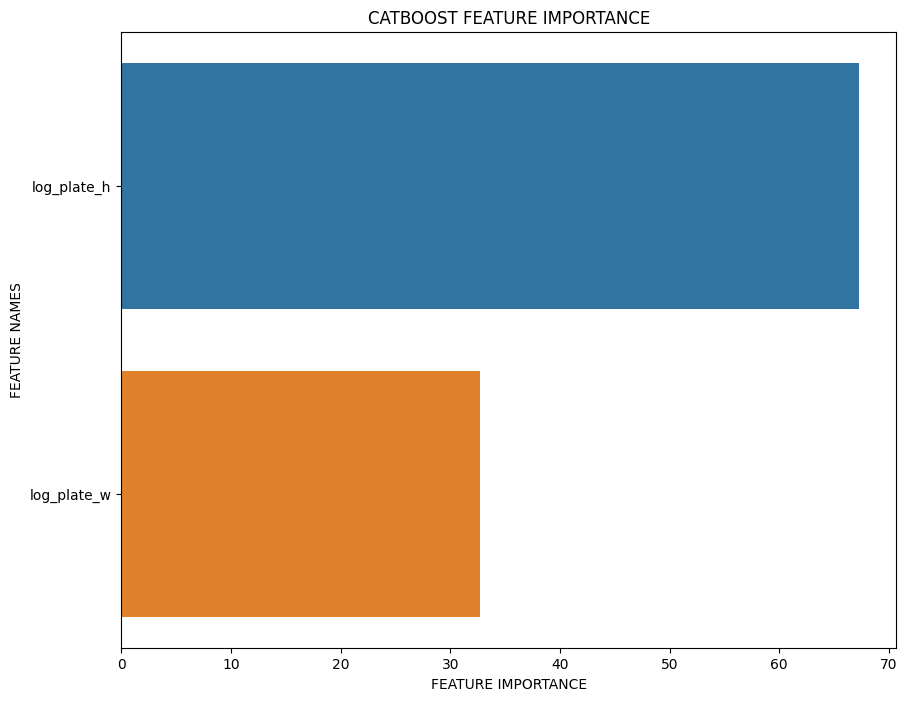

In [15]:
#plot_feature_importance(model_cb.get_feature_importance(), train_df[features].get_feature_names(), 'CATBOOST')
plot_feature_importance(model_cb.get_feature_importance(), features, 'CATBOOST')

Сохраняем предсказания на трейне для анализа ошибок (в 5step)

In [16]:
pred_train = model_cb.predict(train_df[features])
train_df['pred'] = pred_train
train_df.to_csv(os.path.join(DIR_SUBM_TRAIN, 'train_with_pred.csv'), index = False)

# Создаем сабмит

In [17]:
preds = model_cb.predict(test_df[features])
test_df['distance'] = preds

sample_solution_df = test_df[['image_name', 'distance']]

In [18]:
test_img_names = set(os.listdir(DIR_DATA_TEST))

In [19]:
lost_test_items = []

for file_name in test_img_names - set(sample_solution_df['image_name'].values):
    lost_test_items.append([file_name, 0])
    
lost_test_items_df = pd.DataFrame(lost_test_items, columns=['image_name', 'distance'])
sample_solution_df = pd.concat([sample_solution_df, lost_test_items_df])

sample_solution_df.to_csv(os.path.join(DIR_SUBM, '18_repeat2.csv'), sep=';', index=False)

In [20]:
print("Notebook Runtime: %0.2f Minutes"%((time.time() - notebookstart)/60))

Notebook Runtime: 0.17 Minutes
